# PJ Heart diseases indicators analysis.

## Olga Yurlova
### Course "Data Science in Medicine"

In [551]:
import numpy as np
import pandas as pd
pd.reset_option('all')
pd.set_option('mode.use_inf_as_na', False)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

C:\Users\okayu\AppData\Local\Temp/ipykernel_16476/3052610066.py:3: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
C:\Users\okayu\AppData\Local\Temp/ipykernel_16476/3052610066.py:3: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')
C:\Users\okayu\AppData\Local\Temp/ipykernel_16476/3052610066.py:4: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('mode.use_inf_as_na', False)


In [552]:
def outlier_treatment(dataset, factor=1.5):
    """
    Dataset outliers treatment.
    """
    # Count percentiles
    q1=np.percentile(dataset, 25)
    q3=np.percentile(dataset, 75)
    iqr=q3-q1
    lower_bound=q1-(iqr*factor)
    upper_bound=q3+(iqr*factor)
    
    # Treat the outliers
    treated_data=dataset.copy()
    treated_data[(dataset< lower_bound)| (dataset>upper_bound)]= np.nan

    return dataset

In [553]:
def check_normality(dataset):
    """
    Look at the math statistic and check normality of data distribution.
    """
    from scipy.stats import shapiro
    
    # Split the data into two groups
    target= dataset.groupby('target')
    healthy=target.get_group(0)
    heart_disease=target.get_group(1)

    # Shapiro-Wilk Test for Group of healthy
    shapiro_test_healthy = shapiro(healthy)
    print(f"Group of healthy: W-statistic = {shapiro_test_healthy[0]}, p-value = {shapiro_test_healthy[1]}")
    if shapiro_test_healthy[1] < 0.05:
        print('the date of healthy is not normally distributed')
    else:
        print('the date of healthy is normally distributed')
    
    # Shapiro-Wilk Test for Group with Heart Disease
    shapiro_test_heart_disease = shapiro(heart_disease)
    print(f"Group with Heart Disease: W-statistic = {shapiro_test_heart_disease[0]}, p-value = {shapiro_test_heart_disease[1]}")
    if shapiro_test_heart_disease[1] < 0.05:
        print('the date of heart disease having is not normally distributed')
    else:
        print('the date of heart disease having is normally distributed')
        
    return

In [554]:
def categoric_correlation(dataset,Category1:str,Category2:str):
    """
    Statistics of the categorical features.
    """
    from scipy.stats import chi2_contingency
    
    # Define relationship between two categorical features using a crosstab, or cross-tabulation
    crosstab = pd.crosstab(dataset[Category1], df[Category2])
    
    # Perform Chi-Square Test
    chi2, p, dof, ex = chi2_contingency(crosstab)

    print(f"Chi-Square Statistic: {chi2}")
    print(f"P-value: {p}")
    
    sns.heatmap(crosstab, annot=True, fmt="d", cmap="YlGnBu")
    plt.title("Crosstab Heatmap")
    plt.show()

In [555]:
def categoric_encoding(dataset, categorical_columns:list):
    """
    Encoding of the categorical features.
    """
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()

    # Loop through each categorical column and apply LabelEncoder
    for col in categorical_columns:
        dataset[col] = label_encoder.fit_transform(dataset[col])

    return dataset

In [556]:
def numerical_scaling(dataset,numerical_columns:list):
    """
    Scaling of the numerical values.
    """
    # Initialize the StandardScaler
    scaler = StandardScaler()
    
    # Scale and transform the data
    dataset[numerical_columns] = scaler.fit_transform(dataset[numerical_columns])
    
    return dataset

In [557]:
def scores_visualisation(y_test, y_pred):
    """
    Confusion Matrix visualisation.
    """
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix of Predicted Heart Disease presence or absence and true data.')
    plt.show()
    
    return

## Load data.

In [558]:
data = pd.read_csv('heart_disease_uci.csv')

In [559]:
data.head()

,id,age,sex,origin,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


#### Columns describtion:

    id:             Unique id for each patient
    age:            Age of the patient in years
    sex:            sex (Male/Female)
    origin:         place of study
    cp:             chest pain type ([typical angina, atypical angina, non-anginal, asymptomatic])
    trestbps:       resting blood pressure (resting blood pressure (in mm Hg on admission to the hospital))
    chol:           serum cholesterol in mg/dl
    fbs:            if fasting blood sugar > 120 mg/dl (True/False)
    restecg:        resting electrocardiographic results [normal, stt abnormality, lv hypertrophy]
    thalch:         maximum heart rate achieved
    exang:          exercise-induced angina (True/ False)
    oldpeak:        ST depression induced by exercise relative to rest
    slope:          the slope of the peak exercise ST segment
    ca:             number of major vessels (0-3) colored by fluoroscopy
    thal:           [normal; fixed defect; reversible defect]
    num:            Predicted heart disease (0 or 1)


#### The authors of the databases have requested that any publications resulting from the use of the data include the names of the principal investigator responsible for the data collection at each institution. They would be:

    Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
    University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
    University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
    V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.


## Data preprocessing.

In [560]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   origin    920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [561]:
data['num'].value_counts()

num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

#### While the values '1','2','3' predict heart disease, the value '0' defines the healthy people. For machine learning purposes, it is advisable to group data in binary.

In [562]:
df = pd.DataFrame(data)
mapping = {0: 0, 1: 1, 2: 1, 3: 1, 4: 1}

# Map the values in the target column to the new groups
df['target'] = df['num'].map(mapping)
# Drop the old target column
df = df.drop(columns=['num'])
# Drop the id column as irrelevant
df = df.drop(columns=['id'])
df.head()

,age,sex,origin,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [563]:
df['target'].value_counts()

target
1    509
0    411
Name: count, dtype: int64

#### There are approximately equal numbers of healthy people and patients with heart disease in the database.

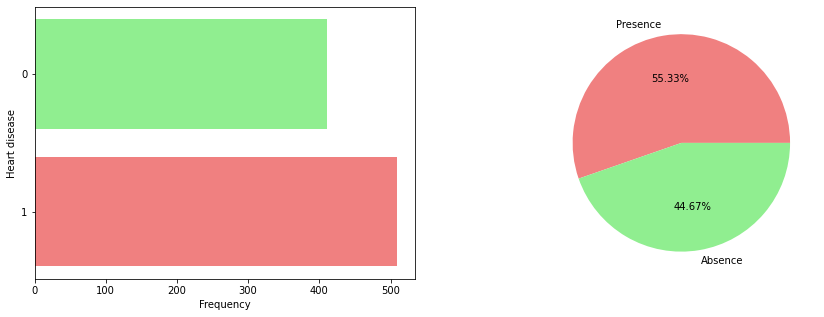

In [564]:
target=df['target'].value_counts()
colors=['lightcoral','lightgreen']
figure, axes=plt.subplots(1,2, figsize=(15,5))

axes[0].barh(y=target.index.astype(str), width=target.values, color=colors)
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Heart disease')
axes[1].pie(target.values, labels=['Presence', 'Absence'], colors=colors, autopct='%.2f%%')
plt.show()

Checking for missing values

In [565]:
df.isnull().sum()

age           0
sex           0
origin        0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64

In [566]:
df.isnull().sum(axis=1)

0      0
1      0
2      0
3      0
4      0
      ..
915    3
916    7
917    2
918    7
919    3
Length: 920, dtype: int64

#### Because the dataset includes sensitive medical data, filling missing values with mean or mode values is not recommended.

In [567]:
# Replace infinities with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
df.dropna(inplace=True)


In [568]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299 entries, 0 to 748
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       299 non-null    int64  
 1   sex       299 non-null    object 
 2   origin    299 non-null    object 
 3   cp        299 non-null    object 
 4   trestbps  299 non-null    float64
 5   chol      299 non-null    float64
 6   fbs       299 non-null    object 
 7   restecg   299 non-null    object 
 8   thalch    299 non-null    float64
 9   exang     299 non-null    object 
 10  oldpeak   299 non-null    float64
 11  slope     299 non-null    object 
 12  ca        299 non-null    float64
 13  thal      299 non-null    object 
 14  target    299 non-null    int64  
dtypes: float64(5), int64(2), object(8)
memory usage: 37.4+ KB


In [569]:
df.isnull().sum()

age         0
sex         0
origin      0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [570]:
df.isnull().sum(axis=1)

0      0
1      0
2      0
3      0
4      0
      ..
299    0
300    0
301    0
508    0
748    0
Length: 299, dtype: int64

#### The dataset contains both numeric and categorical values. For exploratory data analysis, it is advisable to divide the data into appropriate groups.

### EDA of numerical data.

In [571]:
numeric = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'target']

In [572]:
df[numeric] = outlier_treatment(df[numeric])

In [573]:
check_normality(df[numeric])

Group of healthy: W-statistic = 0.8425946235656738, p-value = 6.71956064221e-32
the date of healthy is not normally distributed
Group with Heart Disease: W-statistic = 0.8439850211143494, p-value = 7.357342781683668e-30
the date of heart disease having is not normally distributed


In [574]:
df[numeric].describe(include='all')

,age,trestbps,chol,thalch,oldpeak,ca,target
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,54.521739,131.715719,246.785953,149.327759,1.058528,0.672241,0.464883
std,9.030264,17.747751,52.532582,23.121062,1.162769,0.937438,0.499601
min,29.000000,94.000000,100.000000,71.000000,0.000000,0.000000,0.000000
25%,48.000000,120.000000,211.000000,132.500000,0.000000,0.000000,0.000000
50%,56.000000,130.000000,242.000000,152.000000,0.800000,0.000000,0.000000
75%,61.000000,140.000000,275.500000,165.500000,1.600000,1.000000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,3.000000,1.000000


In [575]:
# Check data correlation
df[numeric].corr(method='spearman')

,age,trestbps,chol,thalch,oldpeak,ca,target
age,1.000000,0.294627,0.183580,-0.383994,0.249087,0.383070,0.236056
trestbps,0.294627,1.000000,0.140869,-0.049598,0.155534,0.076636,0.132335
chol,0.183580,0.140869,1.000000,-0.023664,0.018354,0.139908,0.106593
thalch,-0.383994,-0.049598,-0.023664,1.000000,-0.439465,-0.279205,-0.434501
oldpeak,0.249087,0.155534,0.018354,-0.439465,1.000000,0.260626,0.414202
ca,0.383070,0.076636,0.139908,-0.279205,0.260626,1.000000,0.482963
target,0.236056,0.132335,0.106593,-0.434501,0.414202,0.482963,1.000000


<AxesSubplot:>

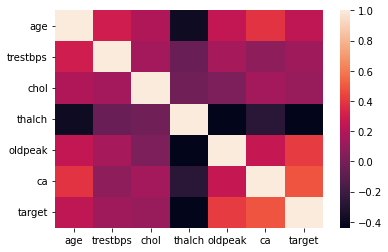

In [576]:
sns.heatmap(df[numeric].corr(method='spearman'))

#### The correlation heatmap demonstrates a strong correlation between the number of major vessels colored by fluoroscopy, ages of patient, ST depression and the target variable (presence or absence of heart disease)

In [577]:
from scipy.stats import pearsonr, spearmanr, kendalltau
r = pearsonr(df['ca'], df['age'])
print('Pearson correlation:', r[0], 'p-value:', r[1])

Pearson correlation: 0.3627635052076773 p-value: 9.920919811828042e-11


In [578]:
r = spearmanr(df['ca'], df['oldpeak'])
print('Spearman correlation:', r[0], 'p-value:', r[1])

Spearman correlation: 0.2606260854550495 p-value: 4.948954002990665e-06


In [579]:
r_ca_heart_disease = pearsonr(df['ca'], df['target'])
print('Ca vs. Heart Disease:', r_ca_heart_disease)
r_old_peak_heart_disease = pearsonr(df['oldpeak'], df['target'])
print('Oldpeak vs. Heart Disease:', r_old_peak_heart_disease)
r_age_heart_disease = pearsonr(df['age'], df['target'])
print('Age vs. Heart Disease:', r_age_heart_disease)

Ca vs. Heart Disease: (0.4553980878971928, 1.0279513505339087e-16)
Oldpeak vs. Heart Disease: (0.4249472689646413, 1.5353648495103936e-14)
Age vs. Heart Disease: (0.22349750720542, 9.7044958993712e-05)


#### A p value less than 0.05 confirms the rejection of the hypothesis about the absence of correlation between the variables under consideration.

### EDA of categorical data.

In [580]:
df.drop(['origin'], axis=1, inplace=True)

In [581]:
categoric = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope','thal','target']

In [582]:
df[categoric].head()

,sex,cp,fbs,restecg,exang,slope,thal,target
0,Male,typical angina,True,lv hypertrophy,False,downsloping,fixed defect,0
1,Male,asymptomatic,False,lv hypertrophy,True,flat,normal,1
2,Male,asymptomatic,False,lv hypertrophy,True,flat,reversable defect,1
3,Male,non-anginal,False,normal,False,downsloping,normal,0
4,Female,atypical angina,False,lv hypertrophy,False,upsloping,normal,0


#### Set up hypothese that there is no association between the categorical variables. For EDA use Chi-Square Statistic, which indicates the magnitude of the difference between the observed and expected frequencies.

Chi-Square Statistic: 22.56759415762495
P-value: 2.028779736181713e-06


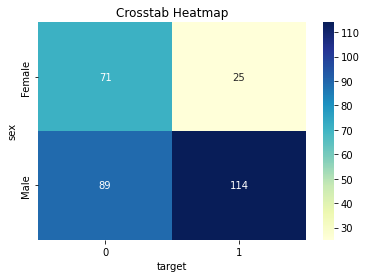

In [583]:
categoric_correlation(df[categoric],'sex','target')

Chi-Square Statistic: 78.91278890176218
P-value: 5.250756261663884e-17


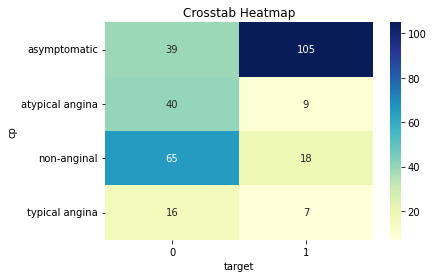

In [584]:
categoric_correlation(df[categoric],'cp','target')

Chi-Square Statistic: 0.0
P-value: 1.0


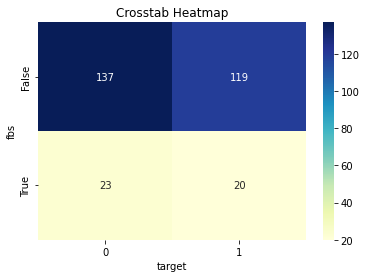

In [585]:
categoric_correlation(df[categoric],'fbs','target')

#### Since the p-value is greater than 0.05, fail to reject the hypothesis. There is no statistically significant association between fasting blood sugar in 2 hours and presence or absence heart disease.

Chi-Square Statistic: 8.776152768026458
P-value: 0.012424606419337495


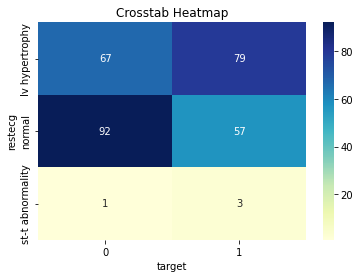

In [586]:
categoric_correlation(df[categoric],'restecg','target')

#### Since the p-value is greater than 0.05, fail to reject the hypothesis. There is no statistically significant association between resting electrocardiographic results  and presence or absence heart disease.

Chi-Square Statistic: 52.74338913585041
P-value: 3.8010057921072105e-13


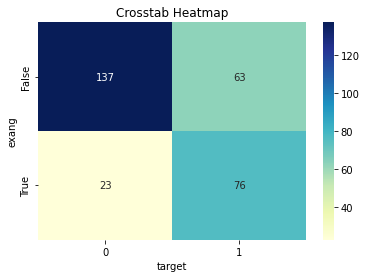

In [587]:
categoric_correlation(df[categoric],'exang','target')

Chi-Square Statistic: 44.771628206170924
P-value: 1.8965507220173321e-10


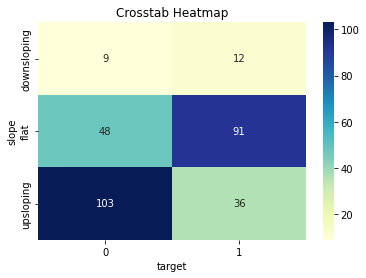

In [588]:
categoric_correlation(df[categoric],'slope','target')

Chi-Square Statistic: 84.2540152329356
P-value: 5.063759291403921e-19


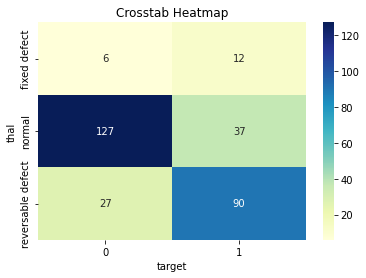

In [589]:
categoric_correlation(df[categoric],'thal','target')

#### Data on fasting blood sugar in 2 hours and resting electrocardiographic results  are removed as they do not have a significant impact on the predicted variable. 

PS. This and other conclusion is based on the introduced data. Nevertheless, in reality, the correlation can be different. For example, the presence of ST-T abnormalities or LV hypertrophy on a resting ECG can be critical in diagnosing heart disease and assessing the risk of future cardiac events. 

In [590]:
df.drop(['fbs','restecg'], axis=1, inplace=True)

In [591]:
# Fit and transform the categorical columns
categorical_columns = ['sex', 'cp', 'exang', 'slope','thal','target']
categoric_encoding(df, categorical_columns)

,age,sex,cp,trestbps,chol,thalch,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145.0,233.0,150.0,0,2.3,0,0.0,0,0
1,67,1,0,160.0,286.0,108.0,1,1.5,1,3.0,1,1
2,67,1,0,120.0,229.0,129.0,1,2.6,1,2.0,2,1
3,37,1,2,130.0,250.0,187.0,0,3.5,0,0.0,1,0
4,41,0,1,130.0,204.0,172.0,0,1.4,2,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
299,68,1,0,144.0,193.0,141.0,0,3.4,1,2.0,2,1
300,57,1,0,130.0,131.0,115.0,1,1.2,1,1.0,2,1
301,57,0,1,130.0,236.0,174.0,0,0.0,1,1.0,1,1
508,47,1,0,150.0,226.0,98.0,1,1.5,1,0.0,2,1


In [592]:
# Fit and scale dataset
numerical_columns = df.select_dtypes(include=['number']).columns
numerical_columns = numerical_columns.drop('target')
numerical_scaling(df,numerical_columns)

,age,sex,cp,trestbps,chol,thalch,exang,oldpeak,slope,ca,thal,target
0,0.940446,0.687682,1.987204,0.749760,-0.262867,0.029124,-0.703562,1.069475,-2.264299,-0.718306,-2.276554,0
1,1.384143,0.687682,-0.920662,1.596354,0.747722,-1.790447,1.421338,0.380309,-0.640737,2.487269,-0.566279,1
2,1.384143,0.687682,-0.920662,-0.661231,-0.339138,-0.880662,1.421338,1.327912,-0.640737,1.418744,1.143997,1
3,-1.943588,0.687682,1.017915,-0.096835,0.061285,1.632079,-0.703562,2.103224,-2.264299,-0.718306,-0.566279,0
4,-1.499891,-1.454161,0.048627,-0.096835,-0.815830,0.982232,-0.703562,0.294163,0.982825,-0.718306,-0.566279,0
...,...,...,...,...,...,...,...,...,...,...,...,...
299,1.495068,0.687682,-0.920662,0.693320,-1.025575,-0.360784,-0.703562,2.017078,-0.640737,1.418744,1.143997,1
300,0.274900,0.687682,-0.920662,-0.096835,-2.207774,-1.487186,1.421338,0.121872,-0.640737,0.350219,1.143997,1
301,0.274900,-1.454161,0.048627,-0.096835,-0.205664,1.068878,-0.703562,-0.911877,-0.640737,0.350219,-0.566279,1
508,-0.834344,0.687682,-0.920662,1.031958,-0.396341,-2.223678,1.421338,0.380309,-0.640737,-0.718306,1.143997,1


## Data training.

In [593]:
# Define features and target
X = df.drop('target', axis=1)
y = df['target']

In [594]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [595]:
from sklearn.tree import DecisionTreeClassifier
# Initialize the DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred1 = model.predict(X_test)

## Evaluation.

In [596]:
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred1)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred1)
print("Accuracy:", accuracy)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred1)
print("Confusion Matrix:\n", conf_matrix)

# Classification report
class_report = classification_report(y_test, y_pred1)
print("Classification Report:\n", class_report)

Mean Absolute Error (MAE): 0.2222222222222222
Accuracy: 0.7777777777777778
Confusion Matrix:
 [[20  8]
 [ 2 15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.71      0.80        28
           1       0.65      0.88      0.75        17

    accuracy                           0.78        45
   macro avg       0.78      0.80      0.78        45
weighted avg       0.81      0.78      0.78        45



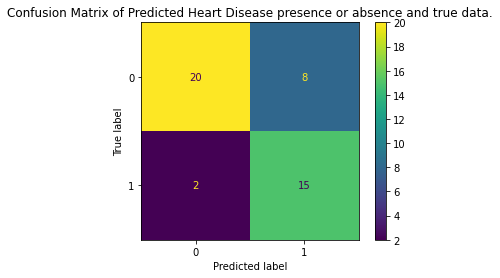

In [597]:
scores_visualisation(y_test, y_pred1)

### Decision Tree Classifier is a simple and effective machine learning model. Accuracy, MAE, and the confusion matrix are good enough to accept this model. Nevertheless, there are more effective models for classification purposes. Take the Random Forest Classifier for comparison.

In [598]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred2 = model.predict(X_test)

In [599]:
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred2)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy:", accuracy)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred2)
print("Confusion Matrix:\n", conf_matrix)

# Classification report
class_report = classification_report(y_test, y_pred2)
print("Classification Report:\n", class_report)

Mean Absolute Error (MAE): 0.13333333333333333
Accuracy: 0.8666666666666667
Confusion Matrix:
 [[24  4]
 [ 2 15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89        28
           1       0.79      0.88      0.83        17

    accuracy                           0.87        45
   macro avg       0.86      0.87      0.86        45
weighted avg       0.87      0.87      0.87        45



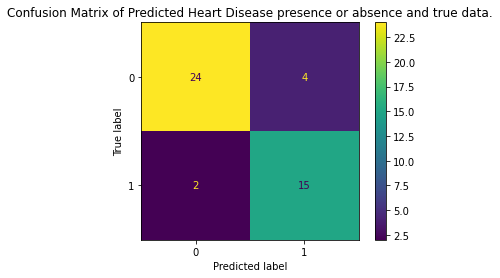

In [600]:
scores_visualisation(y_test, y_pred2)

## Conclusion.

## The RandomForestClassifier model was learned with an accuracy of 87% and an MAE of 0.13. The confusion matrix also shows acceptable values for the prediction of heart disease.